In [1]:
import glob
import os.path as osp
import pickle
import random
import numpy as np
import json
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import models, transforms
import matplotlib.pyplot as plt

import datasets.dataset as dataset
from datasets.load_adni import load_adni2
import models.models as models
from utils.data_class import BrainDataset
import torchio as tio
from tqdm import tqdm
#from models.models import Vgg16, FujiNet1

/home/ryo32/medical-onbording/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# dataloader作成時にラベル情報を数値に変換するために使用するdict型変数
CLASS_MAP = {
    "CN": 0,
    "AD": 1,
}
# 再現性を保つために設定しておく値
SEED_VALUE = 0

In [3]:
# seed値を設定（random, Numpy, PyTorch）
def fix_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.benchmark = (
        False  # この行をFalseにすると再現性はとれるが、速度が落ちる
    )
    torch.backends.cudnn.deterministic = True
    return

fix_seed(0)

In [4]:
# 脳MRIの画像を読み込み（今回は"CN", "AD"のみ）
dataset = load_adni2(classes=["CN", "AD"],size="half", unique=True, mni=False, strength=["3.0"])

# datasetの枚数を表示
len(dataset)

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 571/571 [00:39<00:00, 14.60it/s]


571

In [5]:
# datasetの1枚の情報を見てみる
dataset[0]

{'pid': '098_S_4003',
 'sex': 'F',
 'age': '72.4137',
 'weight': '56.7',
 'day': '2011-03-22',
 'uid': '225425',
 'preprocessing': 'MT1; GradWarp; N3m',
 'slice_thickness': '1.2',
 'plane': 'SAGITTAL',
 'x': '1.0156',
 'y': '1.0156',
 'manufacturer': 'GE MEDICAL SYSTEMS',
 'model': 'DISCOVERY MR750',
 'strength': '3.0',
 'class': 'CN',
 'mmse': '30.0',
 'moca': '24.0',
 'class_base': 'CN',
 'mmse_base': '30.0',
 'moca_base': '24.0',
 'path_full': '/data2/radiology_datas/clean3/ADNI2/full/rigid/225425.nii',
 'path_half': '/data2/radiology_datas/clean3/ADNI2/half/rigid/225425.nii',
 'path_full_mni': '/data2/radiology_datas/clean3/ADNI2/full/trsaa/225425.nii',
 'path_half_mni': '/data2/radiology_datas/clean3/ADNI2/half/trsaa/225425.nii',
 'voxel': memmap([[[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ...

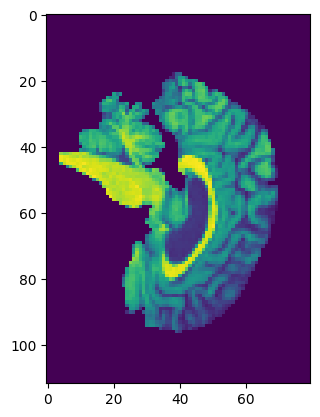

In [6]:
# datasetの画像を1枚見てみる
%matplotlib inline
plt.imshow(dataset[0]["voxel"][40,:,:])

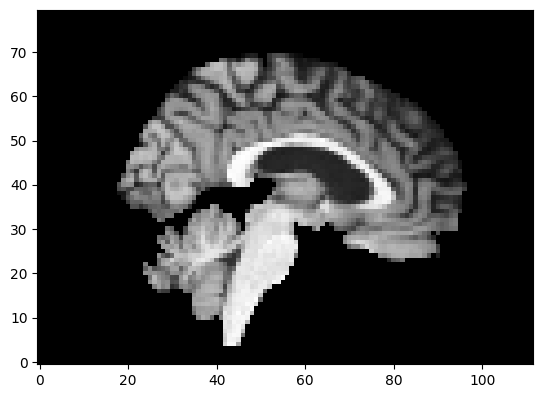

In [7]:
# datasetの画像を1枚見てみる
%matplotlib inline
plt.imshow(dataset[0]["voxel"][40,:,:].T, origin="lower", cmap="gray")

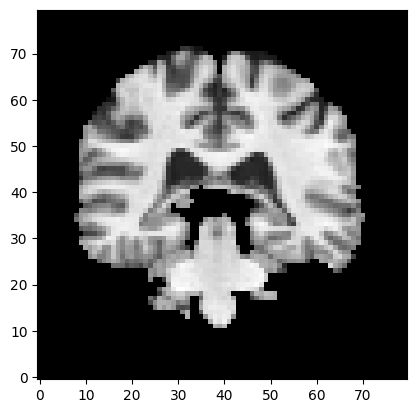

In [8]:
# datasetの画像を1枚見てみる
%matplotlib inline
plt.imshow(dataset[0]["voxel"][:,48,:].T, origin="lower", cmap="gray")

In [9]:
# datasetの」中から使用する情報をそれぞれ取ってくる
pids = []
voxels = np.zeros((len(dataset), 80, 112, 80))
labels = np.zeros(len(dataset))
for i in tqdm(range(len(dataset))):
    pids.append(dataset[i]["pid"])
    voxels[i] = dataset[i]["voxel"]
    # voxels[i] = normalize(voxels[i], np.min(voxels[i]), np.max(voxels[i]))
    labels[i] = CLASS_MAP[dataset[i]["class"]]
pids = np.array(pids)

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 571/571 [00:02<00:00, 215.32it/s]


In [10]:
# trainとtest用の画像を、同じ患者が分かれて入らないように分ける。

from sklearn.model_selection import StratifiedGroupKFold, train_test_split

# train_datadict, val_datadict = train_test_split(dataset, test_size=0.2, shuffle=True, random_state=SEED_VALUE)

pids = []
for i in range(len(dataset)):
    pids.append(dataset[i]["pid"])
gss = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=SEED_VALUE)
train_idx, val_idx = list(gss.split(voxels,labels, groups=pids))[0]
train_voxels = voxels[train_idx]
val_voxels = voxels[val_idx]
train_labels = labels[train_idx]
val_labels = labels[val_idx]

len(train_voxels)

456

In [11]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    
g = torch.Generator()
g.manual_seed(0)

In [12]:
# train/val dataset を作成
train_set = BrainDataset(train_voxels, train_labels)
val_set = BrainDataset(val_voxels, val_labels)

print("size of the training dataset = ", len(train_set))
print("size of the validation dataset = ", len(val_set))
print("training image shape = {}, training label = {}".format(train_set(0)[0].shape, train_set(0)[1]))
print("test image shape = {}, test label = {}".format(val_set(0)[0].shape, val_set(0)[1]))

size of the training dataset =  456
size of the validation dataset =  115
training image shape = (1, 80, 112, 80), training label = 0.0
test image shape = (1, 80, 112, 80), test label = 0.0


In [13]:
# Function line up input images and output images
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error


def show_image(image):    
    %matplotlib inline

    fig = plt.figure(figsize=(18,5),dpi=600)
    X, Y = 1, 6
    
    for i in range(6):
        imgplot = i + 1
        ax1 = fig.add_subplot(X, Y, imgplot)
        print(f"type={image.dtype}")
        img = np.flip(image.reshape(80, 112, 80).transpose(1,2,0)[50+i],0)
        plt.axis("off")
        plt.imshow(img,cmap="gray")
        plt.tick_params(labelsize=8)
        
    plt.show()

type=float32
type=float32
type=float32
type=float32
type=float32
type=float32


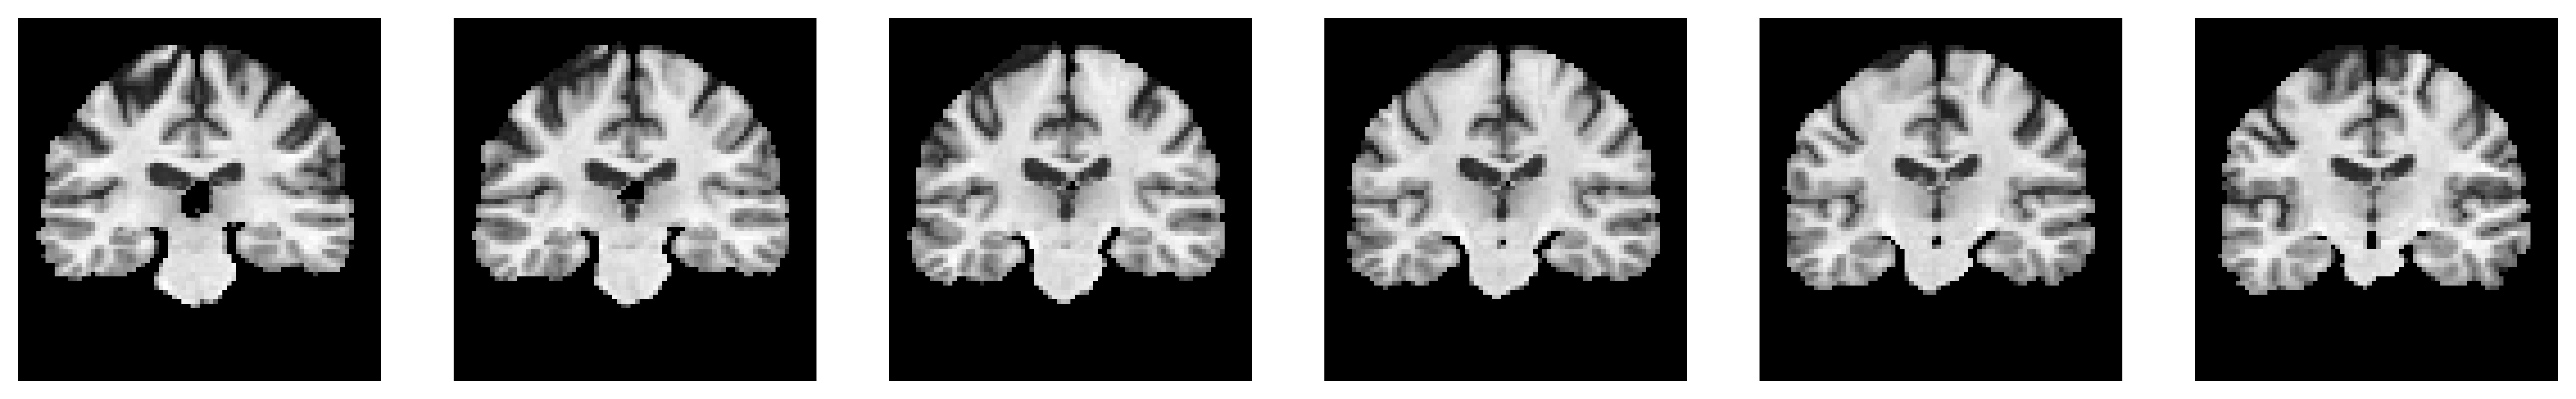

In [14]:
idx = 20
image, label = train_set(idx)

show_image(image)

mean= 0.13431239
max=1.0 min=0.0
0.0


/tmp/ipykernel_1850646/589869620.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


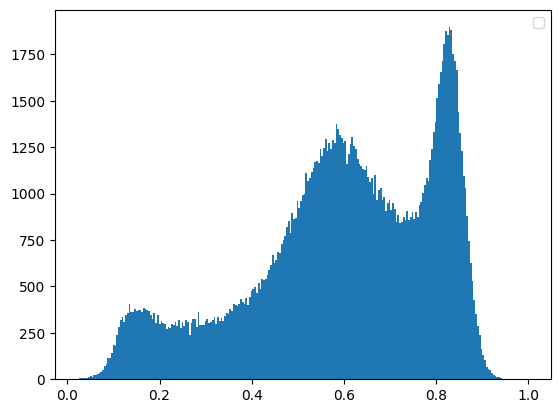

In [15]:
# 画像１枚あたりの輝度値ヒストグラム
print("mean=", image.mean())
print(f"max={image.max()} min={image.min()}")
print(label)
#imge = np.clip(image, 0, None)
show_img = image.reshape(80*112*80)
plt.hist(show_img[show_img > 0.01], bins=255)
#plt.title("Accuracy")
#plt.xlabel("Epoch")
#plt.ylabel("Accuracy")
plt.legend()

571


(array([1.02000e+02, 2.71000e+02, 5.02000e+02, 8.44000e+02, 1.39800e+03,
        2.05400e+03, 2.87700e+03, 3.66600e+03, 4.71100e+03, 6.06900e+03,
        7.46600e+03, 9.24900e+03, 1.14480e+04, 1.41570e+04, 1.69070e+04,
        2.01130e+04, 2.43240e+04, 2.88540e+04, 3.41290e+04, 4.04420e+04,
        4.70330e+04, 5.42280e+04, 6.24160e+04, 7.05740e+04, 7.93940e+04,
        8.94480e+04, 9.89030e+04, 1.08930e+05, 1.19000e+05, 1.29422e+05,
        1.39804e+05, 1.51134e+05, 1.61218e+05, 1.71952e+05, 1.83945e+05,
        1.94296e+05, 2.06093e+05, 2.14392e+05, 2.22193e+05, 2.29637e+05,
        2.35215e+05, 2.38163e+05, 2.39691e+05, 2.39949e+05, 2.38516e+05,
        2.36014e+05, 2.32964e+05, 2.30292e+05, 2.25899e+05, 2.23759e+05,
        2.19174e+05, 2.16044e+05, 2.12820e+05, 2.10655e+05, 2.06574e+05,
        2.04247e+05, 2.00943e+05, 1.98417e+05, 1.95716e+05, 1.92573e+05,
        1.91269e+05, 1.90242e+05, 1.87203e+05, 1.87179e+05, 1.85957e+05,
        1.85255e+05, 1.85051e+05, 1.84688e+05, 1.84

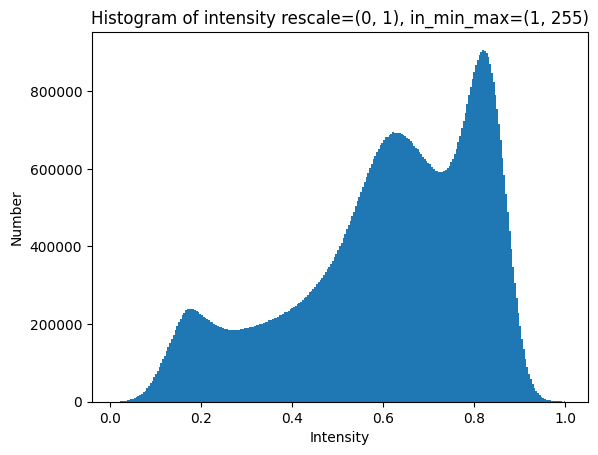

In [16]:
image_list = []
max = 0.01
for image, label in train_set:
    if max < image.max():
        max = image.max()
    image_reshape = image.reshape(80*112*80)
    image_list.append(image_reshape)

for image, label in val_set:
    if max < image.max():
        max = image.max()
    image_reshape = image.reshape(80*112*80)
    image_list.append(image_reshape)
print(len(image_list))

imagelist = np.concatenate(image_list)
plt.title("Histogram of intensity rescale=(0, 1), in_min_max=(1, 255)")
plt.xlabel("Intensity")
plt.ylabel("Number")
plt.hist(imagelist[imagelist > 0.01], bins=255)

In [17]:
print(max)

1.0


In [18]:
train_dataloader = DataLoader(train_set, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_set, batch_size=16, shuffle=False)

In [19]:
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.pool = nn.AvgPool3d(kernel_size=2,stride=2,padding=0)
        self.conv1 = nn.Conv3d(1,3,kernel_size=3,stride=1,padding=1)
        self.conv2 = nn.Conv3d(3,3,kernel_size=3,stride=1,padding=1)
        self.conv3 = nn.Conv3d(3,32,kernel_size=3,stride=1,padding=1)
        self.conv4 = nn.Conv3d(32,64,kernel_size=3,stride=1,padding=1)

        self.batchnorm3d1 = nn.BatchNorm3d(3)
        self.batchnorm3d12 = nn.BatchNorm3d(3)
        self.batchnorm3d2 = nn.BatchNorm3d(32)
        self.batchnorm3d3 = nn.BatchNorm3d(64)


        self.fc1=nn.Linear(89600,512,bias=True)
        self.batchnorm1=nn.BatchNorm1d(512)
        self.dropout=nn.Dropout(p=0.5)

        self.fc2=nn.Linear(512,2,bias=True)


    def forward_conv(self,x):
        x=F.relu(self.batchnorm3d1(self.conv1(x)))
        x=F.relu(self.batchnorm3d12(self.conv2(x)))
        x=self.pool(x)

        x=F.relu(self.batchnorm3d2(self.conv3(x)))
        x=self.pool(x)
        x=F.relu(self.batchnorm3d3(self.conv4(x)))    
        x=self.pool(x)

        x=x.view(x.size(0),-1)

        return x

    def forward(self,x):
        x=self.forward_conv(x)
        x=F.relu(self.batchnorm1(self.fc1(x)))
        x=self.dropout(x)
        x=self.fc2(x)

        return x

    def extract_features(self,x):
        x=self.forward_conv(x)
        x=F.relu(self.batchnorm1(self.fc1(x)))


        return x

        
        

In [20]:
net=CNN()

In [21]:
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(params=net.parameters(), lr=0.0005, momentum=0.9)
optimizer = optim.Adam(params=net.parameters(), lr=0.001)

In [22]:
def train_model(net, train_dataloader, val_dataloader, criterion, optimizer, num_epochs):

    #nvidia-smiで確認してからcudaの番号を決める
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net.to(device)
    print("Use divice = ", device)
    
    log_path = "./log/" + "output" + "_cnn/"

    for epoch in range(num_epochs):
        # train
        net.train()
        loss_avg = 0.0
        acc_avg = 0.0
        for inputs, labels in train_dataloader:
            inputs = inputs.to(device=device, dtype=torch.float32)
            labels = labels.to(device, dtype=torch.long)

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            acc_avg += torch.mean((preds == labels).float()).item() / len(train_dataloader)
            loss_avg += loss.item() / len(train_dataloader)
        train_losses.append(loss_avg)
        train_accs.append(acc_avg)

        # evaluate
        loss_avg = 0.0 
        acc_avg = 0.0
        net.eval()
        for inputs, labels in val_dataloader:
            inputs = inputs.to(device=device, dtype=torch.float32)
            labels = labels.to(device, dtype=torch.long)
            with torch.no_grad():
                outputs = net(inputs)
                loss = criterion(outputs, labels)
            
            _, preds = torch.max(outputs, 1)
            acc_avg += torch.mean((preds == labels).float()).item() / len(val_dataloader)
            loss_avg += loss.item() / len(val_dataloader)

        test_losses.append(loss_avg)
        test_accs.append(acc_avg)
        print(f"EPOCH {epoch+1}  || train loss : {train_losses[epoch]:.4f}, test loss : {test_losses[epoch]:.4f} || train acc : {train_accs[epoch]:.4f} test acc : {test_accs[epoch]:.4f}")

    torch.save(net.state_dict(), log_path + "cnn_weight_1.pth")

In [23]:
num_epochs = 30

train_losses = []
test_losses = []
train_accs = []
test_accs = []

train_model(net, train_dataloader, val_dataloader, criterion, optimizer, num_epochs)

Use divice =  cuda:0
EPOCH 1  || train loss : 0.6387, test loss : 1.7909 || train acc : 0.6918 test acc : 0.6536
EPOCH 2  || train loss : 0.4212, test loss : 0.5550 || train acc : 0.8147 test acc : 0.6927
EPOCH 3  || train loss : 0.3676, test loss : 0.4671 || train acc : 0.8448 test acc : 0.7318
EPOCH 4  || train loss : 0.2177, test loss : 2.4065 || train acc : 0.9332 test acc : 0.6536
EPOCH 5  || train loss : 0.2175, test loss : 0.8594 || train acc : 0.9267 test acc : 0.5339
EPOCH 6  || train loss : 0.1726, test loss : 0.9663 || train acc : 0.9267 test acc : 0.5729
EPOCH 7  || train loss : 0.0895, test loss : 0.5679 || train acc : 0.9720 test acc : 0.7630
EPOCH 8  || train loss : 0.0671, test loss : 0.5834 || train acc : 0.9828 test acc : 0.8047
EPOCH 9  || train loss : 0.0658, test loss : 0.6334 || train acc : 0.9871 test acc : 0.8099
EPOCH 10  || train loss : 0.0520, test loss : 0.5863 || train acc : 0.9892 test acc : 0.8359
EPOCH 11  || train loss : 0.0457, test loss : 0.6903 || tr

RuntimeError: Parent directory ./log/output_cnn does not exist.

課題

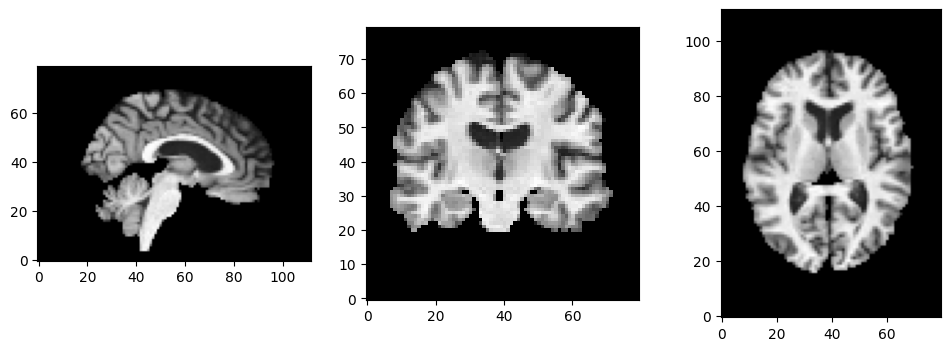

In [25]:
import numpy as np
import matplotlib.pyplot as plt


def show_slices_3planes(volume,axial_index=40,coronal_index=56,sagittal_index=40):
    sagittal_slice=volume[sagittal_index,:,:]
    coronal_slice=volume[:,coronal_index,:]
    axial_slice=volume[:,:,axial_index]
    fig,axes=plt.subplots(1,3,figsize=(12,4))

    axes[0].imshow(sagittal_slice.T,origin="lower",cmap="gray")
    axes[1].imshow(coronal_slice.T,origin="lower",cmap="gray")
    axes[2].imshow(axial_slice.T,origin="lower",cmap="gray")
    plt.show()

sample=dataset[0]["voxel"]
show_slices_3planes(sample,sagittal_index=40,coronal_index=56,axial_index=40)




tsne umap

In [26]:
def extract_features(net,dataloder):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net.to(device)  


    net.eval()
    all_features=[]
    all_labels=[]

    with torch.no_grad():
        for inputs,labels in dataloder:
            inputs=inputs.to(device=device)
            x=net.extract_features(inputs)
            x=x.cpu().numpy()
            l=labels.numpy()

            all_features.append(x)
            all_labels.append(l)

    all_features=np.concatenate(all_features,0)
    all_labels=np.concatenate(all_labels,0)

    return all_features,all_labels
    






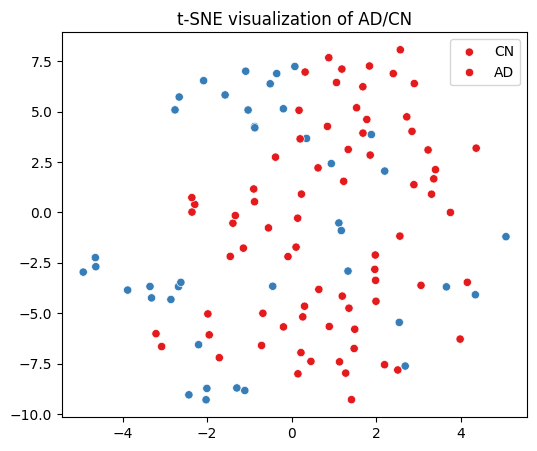

In [27]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

all_features,all_labels=extract_features(net,val_dataloader)

tsne=TSNE(n_components=2,random_state=0)
features_2d=tsne.fit_transform(all_features)

plt.figure(figsize=(6,5))
sns.scatterplot(x=features_2d[:,0], y=features_2d[:,1], 
                hue=all_labels, palette="Set1")
plt.title("t-SNE visualization of AD/CN")
plt.legend(labels=["CN", "AD"])  # CLASS_MAP で 0=CN, 1=AD
plt.show()




In [28]:
# pip install umap-learn してから
import umap

reducer = umap.UMAP(n_components=2, random_state=0)
features_2d_umap = reducer.fit_transform(features)

plt.figure(figsize=(6,5))
sns.scatterplot(x=features_2d_umap[:,0], y=features_2d_umap[:,1],
                hue=labels_, palette="Set1")
plt.title("UMAP visualization of AD/CN")
plt.legend(labels=["CN", "AD"])
plt.show()





AttributeError: module 'umap' has no attribute 'UMAP'

3DCAE実装

In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim




class CAE3D(nn.Module):
    def __init__(self,latent_dim=512):
        super(CAE3D,self).__init__()
        self.latent_dim = latent_dim




        self.enc_conv1=nn.Conv3d(in_channels=1,out_channels=8,kernel_size=3,stride=2,padding=1)
        self.enc_conv2=nn.Conv3d(in_channels=8,out_channels=16,kernel_size=3,stride=2,padding=1)
        self.enc_conv3=nn.Conv3d(in_channels=16,out_channels=32,kernel_size=3,stride=2,padding=1)

        self.enc_fc=nn.Linear(32*10*14*10,latent_dim)




        self.dec_fc=nn.Linear(latent_dim,32*10*14*10)

        self.dec_cov1=nn.ConvTranspose3d(in_channels=32,out_channels=16,kernel_size=3,stride=2,padding=1,output_padding=1)
        self.dec_cov2=nn.ConvTranspose3d(in_channels=16,out_channels=8,kernel_size=3,stride=2,padding=1,output_padding=1)
        self.dec_cov3=nn.ConvTranspose3d(in_channels=8,out_channels=1,kernel_size=3,stride=2,padding=1,output_padding=1)



    def encoder(self,x):
        x=F.relu(self.enc_conv1(x))
        x=F.relu(self.enc_conv2(x))
        x=F.relu(self.enc_conv3(x))

        x=x.view(x.size(0),-1)
        x=self.enc_fc(x)

        return x



    def decoder(self,z):
        x=self.dec_fc(z)
        x=x.view(x.size(0),32,10,14,10)
        x=F.relu(self.dec_cov1(x))
        x=F.relu(self.dec_cov2(x))
        x=self.dec_cov3(x)



        return x


    def forward(self,x):
        z=self.encoder(x)
        rec_x=self.decoder(z)



        return rec_x
        
        

        

        

In [30]:
def train_cae3d(net,train_dataloader,val_dataloader,num_epochs=20):
    device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    net.to(device)



    criterion=nn.MSELoss()
    optimizer=optim.Adam(net.parameters(),lr=1e-3)


    for epoch in range(num_epochs):
        net.train()

        train_loss=0.0

        for images,labels in train_dataloader:
            images=images.to(device,dtype=torch.float32)
            optimizer.zero_grad()

            outputs=net(images)

            loss=criterion(outputs,images)
            loss.backward()
            optimizer.step()

            train_loss+=loss.item()*images.size(0)


        train_loss/=len(train_dataloader.dataset)




        net.eval()
        val_loss=0.0

        with torch.no_grad():
            for images,labels in val_dataloader:
                images=images.to(device,dtype=torch.float32)
                outputs=net(images)
                loss=criterion(outputs,images)


                val_loss=loss.item()*images.size(0)

        val_loss/=len(val_dataloader.dataset)




        print(f"{epoch+1}/{num_epochs}:train_loss={train_loss},val_loss={val_loss}")

In [31]:
net=CAE3D(latent_dim=512)


train_cae3d(net,train_dataloader,val_dataloader,num_epochs=20)

1/20:train_loss=0.056831999698229003,val_loss=0.0008945314780525539
2/20:train_loss=0.02642181201985008,val_loss=0.0005526731033688007
3/20:train_loss=0.018463900508849246,val_loss=0.0004218125472898069
4/20:train_loss=0.014435648068524244,val_loss=0.00036558912176152934
5/20:train_loss=0.012956733848049976,val_loss=0.0003336093914897546
6/20:train_loss=0.012093112624266692,val_loss=0.0003161353828466457
7/20:train_loss=0.011150114467008072,val_loss=0.00029416116683379464
8/20:train_loss=0.010624683788863191,val_loss=0.0002876810324580773
9/20:train_loss=0.010245199772741711,val_loss=0.00028066219680983085
10/20:train_loss=0.010210583166202955,val_loss=0.0002810591588849607
11/20:train_loss=0.009684322908389987,val_loss=0.00026512178389922434
12/20:train_loss=0.00930649282312707,val_loss=0.0002607078250983487
13/20:train_loss=0.009073346346747457,val_loss=0.0002593515602790791
14/20:train_loss=0.008893476374316634,val_loss=0.0002562517867140148
15/20:train_loss=0.008711827069259527,val

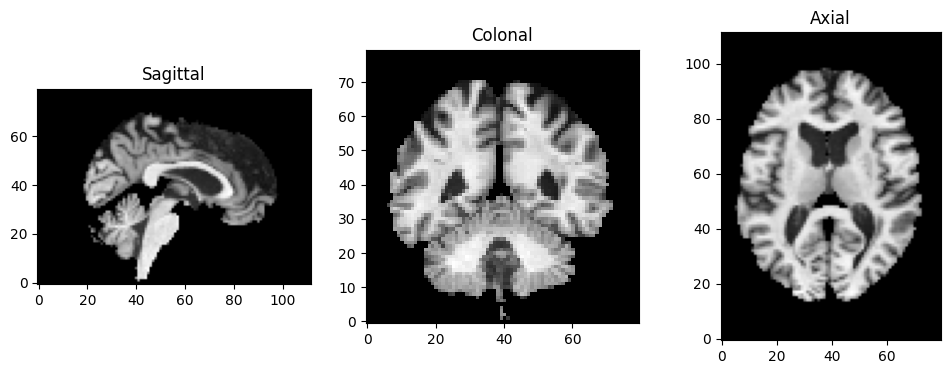

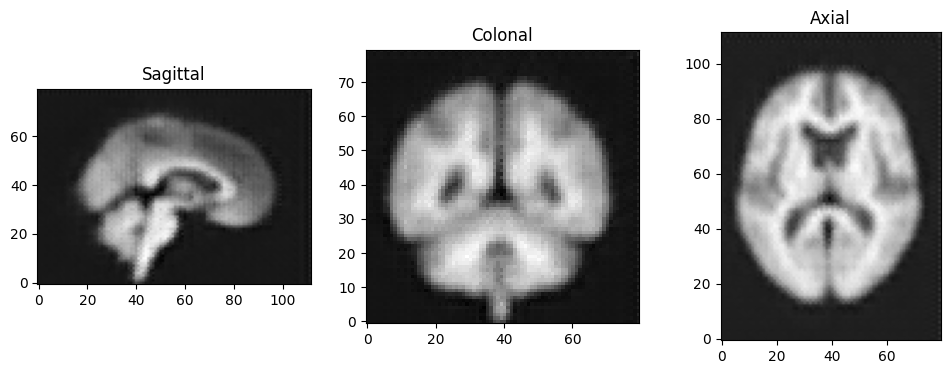

In [32]:
image,label=val_set(0)

device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

image=torch.from_numpy(image).unsqueeze(0).to(device,dtype=torch.float32)

net.eval()
with torch.no_grad():
    output=net(image)


image=image.cpu().numpy()[0,0]
output=output.cpu().numpy()[0,0]

def show_slices_3planes(volume,sagittal=40,colonal=40,axial=40):
    sagittal_slice=volume[sagittal,:,:]
    colonal_slice=volume[:,colonal,:]
    axial_slice=volume[:,:,axial]

    import matplotlib.pyplot as plt

    fig,axes=plt.subplots(1,3,figsize=(12,4))
    axes[0].imshow(sagittal_slice.T,origin="lower",cmap="gray")
    axes[0].set_title("Sagittal")
    axes[1].imshow(colonal_slice.T,origin="lower",cmap="gray")
    axes[1].set_title("Colonal")
    axes[2].imshow(axial_slice.T,origin="lower",cmap="gray")
    axes[2].set_title("Axial")

    plt.show()




show_slices_3planes(image)
show_slices_3planes(output)

In [33]:
def extract_latent_features(net,dataloader):
    net.eval()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    all_features=[]
    all_labels=[]


    with torch.no_grad():
        for images,labels in dataloader:
            images=images.to(device,dtype=torch.float32)
            latent=net.encoder(images)
            latent=latent.cpu().numpy()


            all_features.append(latent)
            all_labels.append(labels.numpy())

    all_features=np.concatenate(all_features,axis=0)
    all_labels=np.concatenate(all_labels,axis=0)

    return all_features,all_labels

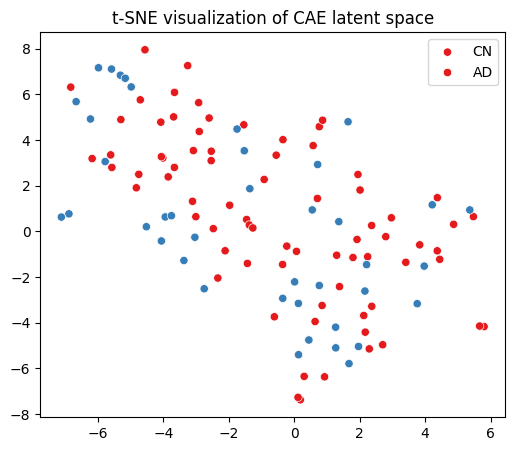

In [34]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

all_features, all_labels = extract_latent_features(net, val_dataloader)

tsne = TSNE(n_components=2, random_state=0)
features_2d = tsne.fit_transform(all_features)

plt.figure(figsize=(6,5))
sns.scatterplot(x=features_2d[:,0], y=features_2d[:,1], 
                hue=all_labels, palette="Set1")
plt.title("t-SNE visualization of CAE latent space")
plt.legend(labels=["CN", "AD"])  # CLASS_MAP に合わせる
plt.show()


3DCAE latent features ロジスティック回帰による分類能の確認

In [35]:
all_features_train,all_labels_train=extract_latent_features(net,train_dataloader)
all_features_val,all_labels_val=extract_latent_features(net,val_dataloader)


from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report



X_train=all_features_train
Y_train=all_labels_train
X_val=all_features_val
Y_val=all_labels_val

scaler=StandardScaler()
scaler.fit(X_train)

X_train_sc=scaler.transform(X_train)
X_val_sc=scaler.transform(X_val)

clf=LogisticRegression(max_iter=1000)
clf.fit(X_train_sc,Y_train)


y_pred=clf.predict(X_val_sc)
acc=accuracy_score(Y_val,y_pred)

print("Accuracy on val latent space:",acc)

cm=confusion_matrix(Y_val,y_pred)
print("Confusion matrix\n",cm)

print(classification_report(Y_val,y_pred,digits=4))

Accuracy on val latent space: 0.7391304347826086
Confusion matrix
 [[64 11]
 [19 21]]
              precision    recall  f1-score   support

         0.0     0.7711    0.8533    0.8101        75
         1.0     0.6562    0.5250    0.5833        40

    accuracy                         0.7391       115
   macro avg     0.7137    0.6892    0.6967       115
weighted avg     0.7311    0.7391    0.7312       115





### 1. 混同行列（Confusion Matrix）

```
[[64 11]
 [19 21]]
```

行は「実際のクラス（Ground Truth）」、列は「予測したクラス（Predicted）」である。  
本稿では、クラスを「0.0＝CN」「1.0＝AD」と仮定する。

- (0,0) = 64：実際は 0.0 を 0.0 と正しく予測  
- (0,1) = 11：実際は 0.0 を 1.0 と誤判定  
- (1,0) = 19：実際は 1.0 を 0.0 と誤判定  
- (1,1) = 21：実際は 1.0 を 1.0 と正しく予測  

クラス 0.0 は 75 サンプル中 64 が正解、11 が誤判定である。  
クラス 1.0 は 40 サンプル中 21 が正解、19 が誤判定である。  
全体 115 サンプルに対して 85 が正解であるため、Accuracy（正解率）は 85/115 ≈ 0.7391 となる。

---

### 2. Precision / Recall / F1-score

- Precision（適合率）: 予測したうち、実際に正解の割合  
- Recall（再現率）: 実際にそのクラスであったもののうち、正しく予測できた割合  
- F1-score: Precision と Recall の調和平均  

今回の結果は以下のとおりである。

#### クラス 0.0
- Precision = 0.7711  
  0.0 と予測した中の約 77.11% が実際に 0.0  
- Recall = 0.8533  
  実際に 0.0 のものの約 85.33% を 0.0 と予測  
- F1 = 0.8101  

#### クラス 1.0
- Precision = 0.6562  
  1.0 と予測した中の約 65.62% が実際に 1.0  
- Recall = 0.5250  
  実際に 1.0 のものの約 52.50% を 1.0 と予測  
- F1 = 0.5833  

---

### 3. 全体の Accuracy と平均指標

Accuracy = 0.7391（85 / 115 ≈ 0.7391）  
macro avg は「クラスごとの指標を単純平均」したもの、weighted avg は「各クラスのサンプル数による重み付き平均」である。

---

### まとめ

- 全体として約 73.91% の正解率を示している。  
- クラス 0.0 のほうが Precision / Recall 共に高く、クラス 1.0 はやや難易度が高い。  
- クラス 0.0 のサンプル数が多いこともあり、weighted avg の F1-score も 0.73 程度となっている。  
- 混同行列の各要素は「(実際のクラス, 予測クラス) の組み合わせで何件あったか」を表す。  
- Precision / Recall / F1 はクラスごとの分類性能を示す。  
- Accuracy ≈ 73.91% は、全 115 サンプル中 85 サンプルが正しく分類された割合である。  
- おおむね「74% 程度の分類性能がある」という意味になる。

3DCAEのlatentベクトルにcenterlossを追加し、実際にtsneを使い可視化する。
また、分類能がどれくらいなのか、指標を用いて検証する。

In [67]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Function
from torch.utils.data import DataLoader
import numpy as np

class CenterLoss(nn.Module):
    def __init__(self, num_classes, feat_dim, size_average=True):
        super(CenterLoss, self).__init__()
        self.centers = nn.Parameter(torch.randn(num_classes, feat_dim))
        self.centerlossfunc = CenterlossFunc.apply
        self.feat_dim = feat_dim
        self.size_average = size_average
    def forward(self, label, feat):
        batch_size = feat.size(0)
        if feat.size(1) != self.feat_dim:
            raise ValueError()
        batch_size_tensor = feat.new_empty(1).fill_(batch_size if self.size_average else 1)
        loss = self.centerlossfunc(feat, label, self.centers, batch_size_tensor)
        return loss

class CenterlossFunc(Function):
    @staticmethod
    def forward(ctx, feature, label, centers, batch_size):
        ctx.save_for_backward(feature, label, centers, batch_size)
        centers_batch = centers.index_select(0, label.long())
        return (feature - centers_batch).pow(2).sum() / 2.0 / batch_size
    @staticmethod
    def backward(ctx, grad_output):
        feature, label, centers, batch_size = ctx.saved_tensors
        centers_batch = centers.index_select(0, label.long())
        diff = centers_batch - feature
        counts = centers.new_ones(centers.size(0))
        ones = centers.new_ones(label.size(0))
        grad_centers = centers.new_zeros(centers.size())
        counts = counts.scatter_add_(0, label.long(), ones)
        grad_centers.scatter_add_(0, label.unsqueeze(1).expand(feature.size()).long(), diff)
        grad_centers = grad_centers / counts.view(-1, 1)
        return -grad_output * diff / batch_size, None, grad_centers / batch_size, None

class CAE3D2(nn.Module):
    def __init__(self, latent_dim):
        super(CAE3D2, self).__init__()
        self.latent_dim = latent_dim
        self.enc_conv1 = nn.Conv3d(1, 8, kernel_size=3, stride=2, padding=1)
        self.enc_conv2 = nn.Conv3d(8, 16, kernel_size=3, stride=2, padding=1)
        self.enc_conv3 = nn.Conv3d(16, 32, kernel_size=3, stride=2, padding=1)
        self.enc_fc = nn.Linear(32 * 10 * 14 * 10, latent_dim)
        self.dec_fc = nn.Linear(latent_dim, 32 * 10 * 14 * 10)
        self.dec_deconv1 = nn.ConvTranspose3d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dec_deconv2 = nn.ConvTranspose3d(16, 8, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dec_deconv3 = nn.ConvTranspose3d(8, 1, kernel_size=3, stride=2, padding=1, output_padding=1)
    def encoder(self, x):
        x = F.relu(self.enc_conv1(x))
        x = F.relu(self.enc_conv2(x))
        x = F.relu(self.enc_conv3(x))
        x = x.view(x.size(0), -1)
        z = self.enc_fc(x)
        return z
    def decoder(self, z):
        x = self.dec_fc(z)
        x = x.view(x.size(0), 32, 10, 14, 10)
        x = F.relu(self.dec_deconv1(x))
        x = F.relu(self.dec_deconv2(x))
        x = self.dec_deconv3(x)
        return x
    def forward(self, x):
        z = self.encoder(x)
        rec = self.decoder(z)
        return rec, z

def train_cae3d_with_centerloss(net, train_loader, val_loader, num_classes=2, alpha=1.0, num_epochs=10, lr_main=1e-3, lr_center=0.5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net.to(device)
    recon_criterion = nn.MSELoss()
    center_loss_fn = CenterLoss(num_classes, feat_dim=net.latent_dim).to(device)
    optimizer_main = optim.Adam(net.parameters(), lr=lr_main)
    optimizer_center = optim.SGD(center_loss_fn.parameters(), lr=lr_center)
    for epoch in range(num_epochs):
        net.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images = images.to(device, dtype=torch.float32)
            labels = labels.to(device, dtype=torch.long)
            optimizer_main.zero_grad()
            optimizer_center.zero_grad()
            rec_x, z = net(images)
            loss_recon = recon_criterion(rec_x, images)
            loss_center = center_loss_fn(labels, z)
            loss = loss_recon + alpha * loss_center
            loss.backward()
            optimizer_main.step()
            optimizer_center.step()
            running_loss += loss.item() * images.size(0)
        epoch_train_loss = running_loss / len(train_loader.dataset)
        net.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images_val, _ in val_loader:
                images_val = images_val.to(device, dtype=torch.float32)
                rec_val, _ = net(images_val)
                lv = recon_criterion(rec_val, images_val)
                val_loss += lv.item() * images_val.size(0)
        val_loss /= len(val_loader.dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}] TrainLoss={epoch_train_loss:.4f}, ValRecon={val_loss:.4f}")
    return center_loss_fn

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

def extract_latent_features2(net, loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net.eval()
    all_feats = []
    all_labels = []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device, dtype=torch.float32)
            _, z = net(images)
            z = z.cpu().numpy()
            l = labels.numpy()
            all_feats.append(z)
            all_labels.append(l)
    all_feats = np.concatenate(all_feats, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    return all_feats, all_labels

def evaluate_classification_in_latent(net, train_loader, val_loader):
    X_train, y_train = extract_latent_features2(net, train_loader)
    X_val, y_val = extract_latent_features2(net, val_loader)
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_sc = scaler.transform(X_train)
    X_val_sc = scaler.transform(X_val)
    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train_sc, y_train)
    pred_val = clf.predict(X_val_sc)
    acc = accuracy_score(y_val, pred_val)
    print("LogisticRegression accuracy =", acc)
    print(classification_report(y_val, pred_val, digits=4))



In [68]:
net=CAE3D2(latent_dim=512)

In [74]:
train_cae3d_with_centerloss(
        net,
        train_dataloader,
        val_dataloader,
        num_classes=2,
        alpha=0.5,
        num_epochs=20,
        lr_main=1e-3,
        lr_center=0.5
    )

  
evaluate_classification_in_latent(net, train_dataloader, val_dataloader)


Epoch [1/20] TrainLoss=13.7464, ValRecon=0.0131
Epoch [2/20] TrainLoss=1.6124, ValRecon=0.0120
Epoch [3/20] TrainLoss=0.3218, ValRecon=0.0118
Epoch [4/20] TrainLoss=0.0749, ValRecon=0.0116
Epoch [5/20] TrainLoss=0.0288, ValRecon=0.0116
Epoch [6/20] TrainLoss=0.0187, ValRecon=0.0116
Epoch [7/20] TrainLoss=0.0159, ValRecon=0.0116
Epoch [8/20] TrainLoss=0.0148, ValRecon=0.0115
Epoch [9/20] TrainLoss=0.0141, ValRecon=0.0115
Epoch [10/20] TrainLoss=0.0136, ValRecon=0.0115
Epoch [11/20] TrainLoss=0.0132, ValRecon=0.0115
Epoch [12/20] TrainLoss=0.0129, ValRecon=0.0115
Epoch [13/20] TrainLoss=0.0127, ValRecon=0.0115
Epoch [14/20] TrainLoss=0.0126, ValRecon=0.0115
Epoch [15/20] TrainLoss=0.0124, ValRecon=0.0115
Epoch [16/20] TrainLoss=0.0123, ValRecon=0.0115
Epoch [17/20] TrainLoss=0.0122, ValRecon=0.0115
Epoch [18/20] TrainLoss=0.0121, ValRecon=0.0115
Epoch [19/20] TrainLoss=0.0121, ValRecon=0.0115
Epoch [20/20] TrainLoss=0.0120, ValRecon=0.0115
LogisticRegression accuracy = 0.7130434782608696

normal CAE cf

|       | precision | recall | f1-score | support |
|-------|----------|--------|----------|---------|
| 0.0   | 0.7711   | 0.8533 | 0.8101   | 75      |
| 1.0   | 0.6562   | 0.5250 | 0.5833   | 40      |
| **accuracy**            |       |        |          | 0.7391   |
| **macro avg**           | 0.7137 | 0.6892 | 0.6967   | 115      |
| **weighted avg**        | 0.7311 | 0.7391 | 0.7312   | 115      |


In [ ]:
# center_loss_fn =train_cae3d_with_centerloss(
#         net,
#         train_dataloader,S
#         val_dataloader,
#         num_classes=2,
#         alpha=1.0,
#         num_epochs=5,
#         lr_main=1e-3,
#         lr_center=0.5
#     )


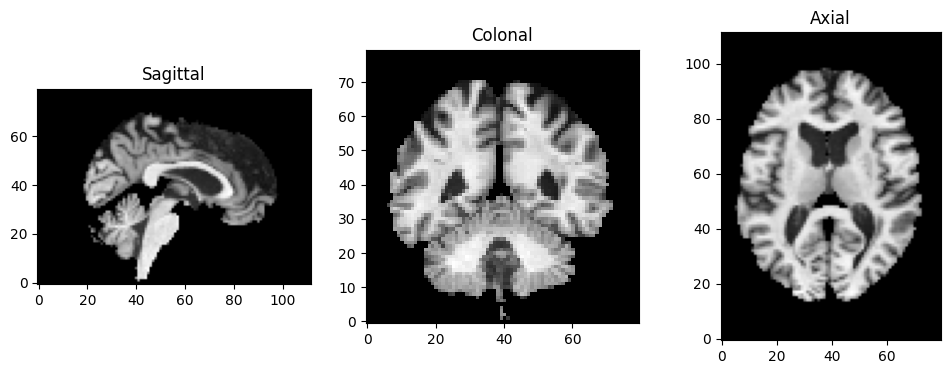

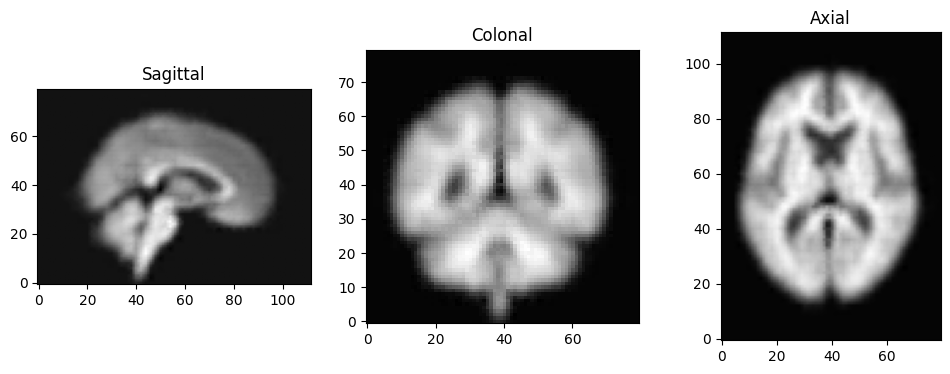

In [75]:
image,label=val_set(0)

device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

image=torch.from_numpy(image).unsqueeze(0).to(device,dtype=torch.float32)


net.eval()
with torch.no_grad():
    output,z=net(image)


image=image.cpu().numpy()[0,0]
output=output.cpu().numpy()[0,0]

def show_slices_3planes(volume,sagittal=40,colonal=40,axial=40):
    sagittal_slice=volume[sagittal,:,:]
    colonal_slice=volume[:,colonal,:]
    axial_slice=volume[:,:,axial]

    import matplotlib.pyplot as plt

    fig,axes=plt.subplots(1,3,figsize=(12,4))
    axes[0].imshow(sagittal_slice.T,origin="lower",cmap="gray")
    axes[0].set_title("Sagittal")
    axes[1].imshow(colonal_slice.T,origin="lower",cmap="gray")
    axes[1].set_title("Colonal")
    axes[2].imshow(axial_slice.T,origin="lower",cmap="gray")
    axes[2].set_title("Axial")

    plt.show()




show_slices_3planes(image)
show_slices_3planes(output)

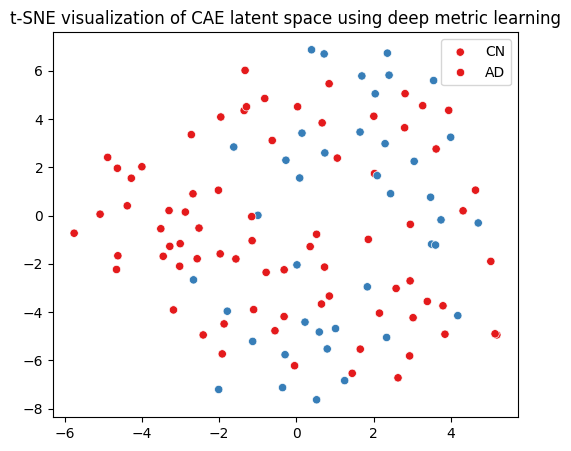

In [76]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

all_features, all_labels = extract_latent_features2(net, val_dataloader)

tsne = TSNE(n_components=2, random_state=0)
features_2d = tsne.fit_transform(all_features)

plt.figure(figsize=(6,5))
sns.scatterplot(x=features_2d[:,0], y=features_2d[:,1], 
                hue=all_labels, palette="Set1")
plt.title("t-SNE visualization of CAE latent space using deep metric learning")
plt.legend(labels=["CN", "AD"])  # CLASS_MAP に合わせる
plt.show()

3DVAE実装

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F



class VAE3D(nn.Module):
    def __init__(self,latent_dim=150):
        super(VAE3D,self).__init__()
        self.latent_dim=latent_dim


        self.enc_conv1=nn.Conv3d(1,8,kernel_size=3,stride=2,padding=1)
        self.enc_conv2=nn.Conv3d(8,16,kernel_size=3,stride=2,padding=1)
        self.enc_conv3=nn.Conv3d(16,32,kernel_size=3,stride=2,padding=1)
        self.fc_mu=nn.Linear(32*10*14*10,latent_dim)
        self.fc_logvar=nn.Linear(32*10*14*10,latent_dim)



        self.fc_decode=nn.Linear(latent_dim,32*10*14*10)
        self.dec_conv1=nn.ConvTranspose3d(32,16,kernel_size=3,stride=2,padding=1, output_padding=1)
        self.dec_conv2=nn.ConvTranspose3d(16,8,kernel_size=3,stride=2,padding=1, output_padding=1)
        self.dec_conv3=nn.ConvTranspose3d(8,1,kernel_size=3,stride=2,padding=1, output_padding=1)


    

    def encoder(self,x):
        x=F.relu(self.enc_conv1(x))
        x=F.relu(self.enc_conv2(x))
        x=F.relu(self.enc_conv3(x))


        x=x.view(x.size(0),-1)

        mu=self.fc_mu(x)
        logvar=self.fc_logvar(x)


        return mu,logvar
    




    def reparametersize(self,mu,logvar):
        eps=torch.randn_like(mu)
        z=mu+torch.sqrt(torch.exp(logvar))*eps

        return z
    





    def decoder(self,z):
        x=self.fc_decode(z)
        x=x.view(-1,32,10,14,10)


        x=F.relu(self.dec_conv1(x))
        x=F.relu(self.dec_conv2(x))
        x=self.dec_conv3(x)

        x=torch.sigmoid(x)

        return x
    


    def forward(self,x):
        mu,logvar=self.encoder(x)
        z=self.reparametersize(mu,logvar)
        x_rec=self.decoder(z)



        return x_rec,mu,logvar


        




        

In [28]:
def vae_loss(x,x_rec,mu,logvar):
    recon_loss=F.mse_loss(x_rec,x,reduction="sum")

    kl_loss=-0.5*torch.sum(1+logvar-mu.pow(2)-logvar.exp())


    return recon_loss+kl_loss,recon_loss,kl_loss

In [29]:
import torch
import torch.optim as optim

latent_dim=150

vae=VAE3D(latent_dim)


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vae.to(device)


optimizer=optim.Adam(vae.parameters(),lr=1e-4)


num_epochs=20


for epoch in range(num_epochs):
    vae.train()
    train_loss=0.0


    for images,labels in train_dataloader:
        images=images.to(device,dtype=torch.float32)
        labels=labels.to(device,dtype=torch.float32)

        optimizer.zero_grad()

        x_rec,mu,logvar=vae(images)
        loss,recon_loss,kl_loss=vae_loss(images,x_rec,mu,logvar)


        loss=loss / images.size(0)


        loss.backward()

        optimizer.step()


        train_loss+=loss.item()*images.size(0)


    avg_loss=train_loss / len(train_dataloader.dataset)

    print(f"current epoch:{epoch+1}/{num_epochs},total_loss:{avg_loss:.4f}")







current epoch:1/20,total_loss:152590.0452
current epoch:2/20,total_loss:135062.6124
current epoch:3/20,total_loss:92082.0636
current epoch:4/20,total_loss:56109.3564
current epoch:5/20,total_loss:35586.9551
current epoch:6/20,total_loss:26425.5335
current epoch:7/20,total_loss:22625.7678
current epoch:8/20,total_loss:20525.5006
current epoch:9/20,total_loss:19137.7667
current epoch:10/20,total_loss:18119.0827
current epoch:11/20,total_loss:17316.6042
current epoch:12/20,total_loss:16668.8523
current epoch:13/20,total_loss:16119.9568
current epoch:14/20,total_loss:15631.6203
current epoch:15/20,total_loss:15224.6741
current epoch:16/20,total_loss:14869.8830
current epoch:17/20,total_loss:14582.9346
current epoch:18/20,total_loss:14327.9326
current epoch:19/20,total_loss:14113.2781
current epoch:20/20,total_loss:13926.2302


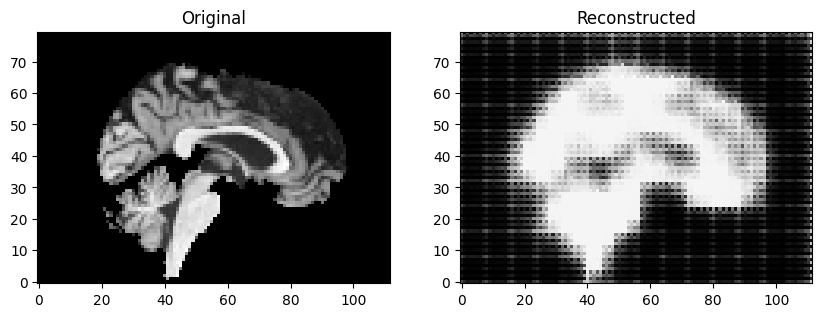

In [30]:
import matplotlib.pyplot as plt
import numpy as np

vae.eval()

with torch.no_grad():
    for images,labels in val_dataloader:
        images=images.to(device,dtype=torch.float32)
        x_rec,mu,logvar=vae(images)

        break


images=images[0].cpu().numpy()
x_rec=x_rec[0].cpu().numpy()


fig,axes=plt.subplots(1,2,figsize=(10,5))

axes[0].imshow(images[0,40,:,:].T,origin="lower",cmap="gray")
axes[0].set_title("Original")

axes[1].imshow(x_rec[0,40,:,:].T,origin="lower",cmap="gray")
axes[1].set_title("Reconstructed")
plt.show()


低次元ベクトルを取得し、分類、可視化等

In [31]:
import numpy as np

import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


vae.eval()

latent_vectors=[]

true_labels=[]

with torch.no_grad():
    for images,labels in val_dataloader:
        images=images.to(device,dtype=torch.float32)


        mu,logvar=vae.encoder(images)
        z=vae.reparametersize(mu,logvar)
        latent_vectors.append(z.cpu().numpy())
        true_labels.append(labels.cpu().numpy())

latent_vectors=np.concatenate(latent_vectors,axis=0)
true_labels=np.concatenate(true_labels,axis=0)




In [32]:
from sklearn.cluster import KMeans



kmeans=KMeans(n_clusters=2,random_state=0)
kmeans.fit(latent_vectors)
predicted_cluster=kmeans.labels_


In [33]:
import numpy as np

cluster_to_label={}
for cluster_id in [0,1]:
    idx=(predicted_cluster==cluster_id)
    labels_in_cluster=true_labels[idx]

    if labels_in_cluster.mean()>0.5:
        assigned_label=1
    else:
        assigned_label=0

    cluster_to_label[cluster_id]=assigned_label

predicted_labels=np.array([cluster_to_label[c] for c in predicted_cluster])



    

In [34]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, adjusted_rand_score


acc=accuracy_score(true_labels,predicted_labels)

print("K-means Accuracy",acc)



ari=adjusted_rand_score(true_labels,predicted_cluster)
print("ARI",ari)

K-means Accuracy 0.6521739130434783
ARI -0.005281293272791678


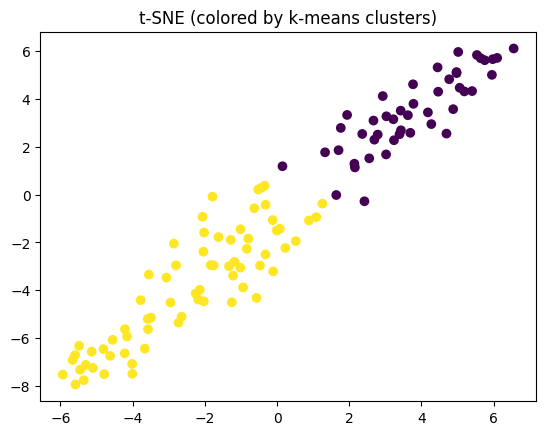

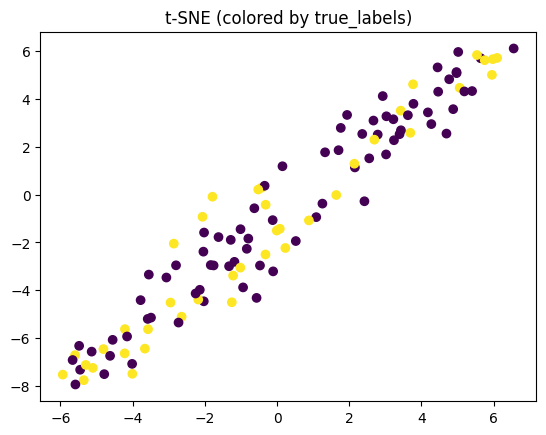

In [35]:
from sklearn.manifold import TSNE

tsne=TSNE(n_components=2,random_state=0)
z_tsne=tsne.fit_transform(latent_vectors)

import matplotlib.pyplot as plt

plt.figure()
plt.scatter(z_tsne[:, 0], z_tsne[:, 1], c=predicted_cluster)
plt.title("t-SNE (colored by k-means clusters)")
plt.show()

plt.figure()
plt.scatter(z_tsne[:, 0], z_tsne[:, 1], c=true_labels)
plt.title("t-SNE (colored by true_labels)")
plt.show()




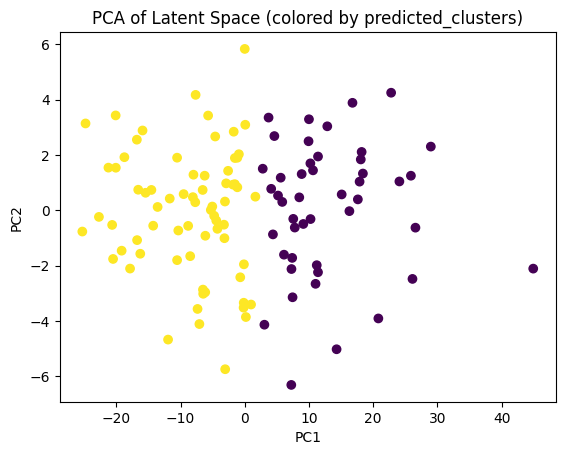

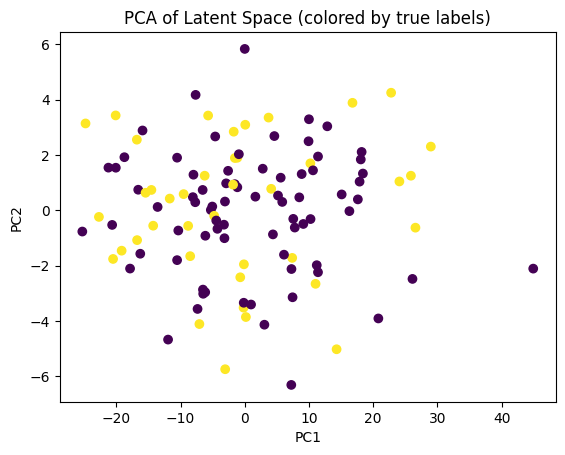

In [36]:
from sklearn.decomposition import PCA

pca=PCA(n_components=2)
z_pca=pca.fit_transform(latent_vectors)

import matplotlib.pyplot as plt



plt.figure()
plt.scatter(z_pca[:, 0], z_pca[:, 1], c=predicted_cluster)
plt.title("PCA of Latent Space (colored by predicted_clusters)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()



plt.figure()
plt.scatter(z_pca[:, 0], z_pca[:, 1], c=true_labels)
plt.title("PCA of Latent Space (colored by true labels)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()






